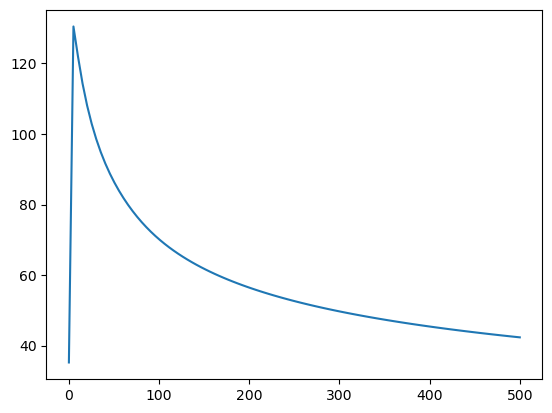

In [54]:
# %matplotlib widget

import agama
import numpy
import matplotlib.pyplot as plt

# working units: 1 Msun, 1 kpc, 1 km/s
agama.setUnits(length=1, velocity=1, mass=1)

# parameters of the host galaxy (a spherical NFW halo; one can add stellar disc
# or even use a standard potential such as McMillan17)
pot_host_params = dict(type="spheroid", gamma=1, beta=3, scaleradius=4.2, densitynorm=1)
# choose the density normalization such that the circular velocity at 10 kpc is 200 km/s
vcirc1 = (-agama.Potential(pot_host_params).force(10, 0, 0)[0] * 10) ** 0.5
pot_host_params["densitynorm"] = (200.0 / vcirc1) ** 2
pot_host = agama.Potential(pot_host_params)

# prepare an interpolation table for the host velocity dispersion profile
df_host = agama.DistributionFunction(type="quasispherical", potential=pot_host)
grid_r = numpy.logspace(-1, 2, 16)  # grid from 0.1 to 100 kpc
grid_sig = (
    agama.GalaxyModel(pot_host, df_host).moments(
        numpy.column_stack((grid_r, grid_r * 0, grid_r * 0)), dens=False, vel=False, vel2=True
    )[:, 0]
    ** 0.5
)
logspl = agama.CubicSpline(numpy.log(grid_r), numpy.log(grid_sig))  # log-scaled spline
sigma = lambda r: numpy.exp(logspl(numpy.log(r)))  # and the un-scaled interpolator

plt.plot(numpy.linspace(0.01, 500, 100), sigma(numpy.linspace(0.01, 500, 100)))
plt.show()

Set initial conditions

In [55]:
plot = False
pyfalcon = None

# parameters for the simulation
T_END = 10.0  # total simulation time
T_UPD = 2**-9  # interval for plotting and updating the satellite mass for the restricted N-body simulation
# timestep of the full N-body sim (typically should be smaller than eps/v, where v is characteristic internal velocity)
TAU = 2**-9
EPS = 0.1  # softening length for the full N-body simulation
LN_LAMBDA = 3.0
SAT_TOTAL_MASS = 1e7
SAT_NUMBER_OF_POINTS = 2000
SEMI_MAJOR_AXIS = 10.0
ECCENTRICITY = 0.1
APOCENTRE = (1 + ECCENTRICITY) * SEMI_MAJOR_AXIS
BOUND_MASS_THRESHOLD = 0.0005

# initial potential of the satellite (a single Dehnen component with a Gaussian cutoff)
pot_sat = agama.Potential(
    type="spheroid",
    gamma=1,
    beta=4,
    scaleradius=10.0/1000,
    outercutoffradius=8.0,
    mass=SAT_TOTAL_MASS,
)
initmass = pot_sat.totalMass()

# create a spherical isotropic DF for the satellite and sample it with particles
df_sat = agama.DistributionFunction(type="quasispherical", potential=pot_sat)
xv, mass = agama.GalaxyModel(pot_sat, df_sat).sample(SAT_NUMBER_OF_POINTS)

# place the satellite at the apocentre of a moderately eccentric orbit
Vcirc = (-APOCENTRE * pot_host.force(APOCENTRE, 0, 0)[0]) ** 0.5
V0 = (1 - ECCENTRICITY) * Vcirc

print(V0)

# initial displacement
r_center = numpy.array([APOCENTRE, 0, 0, 0, V0, 0])
xv += r_center

r_mass = [initmass]
r_traj = [r_center]
r_xv = xv.copy()
time = 0.0  # current simulation time
times_t = [time]
times_u = [time]
orbitfile = "satellite_orbit.txt"  # temp file name for storing the trajectory

179.553910539


Add helper functions to compute orbits accounting for dynamical friction

In [56]:
import scipy
from typing import Callable

def dynamical_friction_acceleration(host_potential, pos, vel, mass, sigma: Callable[[float], float], ln_lambda: float):
    """
    compute the Chandrasekhar's dynamical friction acceleration for a point mass in the host galaxy
    """
    r = sum(pos**2) ** 0.5
    v = sum(vel**2) ** 0.5
    rho = host_potential.density(pos)
    X = v / (2**0.5 * sigma(r))
    return -vel / v * (4 * numpy.pi * agama.G**2 * mass * rho * ln_lambda * (scipy.special.erf(X) - 2 / numpy.pi**0.5 * X * numpy.exp(-X * X)) / v**2)


def orbit_with_df(host_potential, ic, time, timestart, trajsize, mass, initmass, sigma, ln_lambda):
    """
    integrate the orbit of a massive particle in the host galaxy, accounting for dynamical friction
    """
    if mass == 0:
        return agama.orbit(ic=ic, potential=host_potential, time=time, timestart=timestart, trajsize=trajsize)
    times = numpy.linspace(timestart, timestart + time, trajsize)
    traj = scipy.integrate.odeint(
        lambda xv, t: numpy.hstack(
            (
                xv[3:6],
                host_potential.force(xv[:3], t=t)
                + dynamical_friction_acceleration(host_potential, xv[:3], xv[3:6], initmass, sigma, ln_lambda),
            )
        ),
        ic,
        times,
    )
    return times, traj

2000 orbits complete (inf orbits/s)
0  0.002  0.997
2000 orbits complete (inf orbits/s)
1  0.004  0.996
2000 orbits complete (inf orbits/s)
2  0.006  0.993
2000 orbits complete (2000 orbits/s)
3  0.008  0.9905
2000 orbits complete (inf orbits/s)
4  0.010  0.988
2000 orbits complete (inf orbits/s)
5  0.012  0.9875
2000 orbits complete (inf orbits/s)
6  0.014  0.987
2000 orbits complete (2000 orbits/s)
7  0.016  0.986
2000 orbits complete (inf orbits/s)
8  0.018  0.985
2000 orbits complete (inf orbits/s)
9  0.020  0.984
2000 orbits complete (inf orbits/s)
10  0.021  0.9825
2000 orbits complete (inf orbits/s)
11  0.023  0.98
2000 orbits complete (2000 orbits/s)
12  0.025  0.9785
2000 orbits complete (inf orbits/s)
13  0.027  0.977
2000 orbits complete (inf orbits/s)
14  0.029  0.9765
2000 orbits complete (inf orbits/s)
15  0.031  0.9755
2000 orbits complete (2000 orbits/s)
16  0.033  0.9755
2000 orbits complete (inf orbits/s)
17  0.035  0.9745
2000 orbits complete (inf orbits/s)
18  0.037

LinAlgError: SVD did not converge

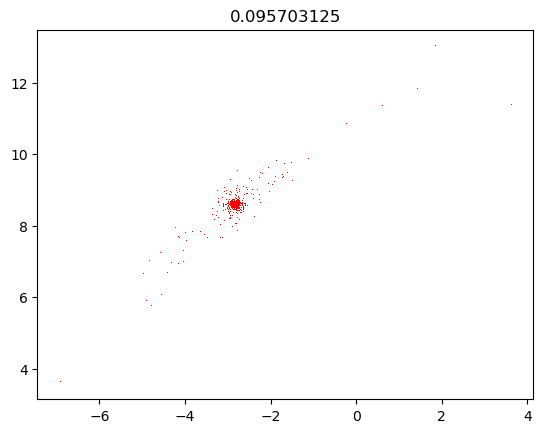

In [57]:
# %matplotlib widget
import os
from scriptslib import ellipse_approx
i = 0
centres = []

while time < T_END:
    i += 1
    # restricted N-body
    # first determine the trajectory of the satellite centre in the host potential
    # (assuming that it moves as a single massive particle)
    time_center, orbit_center = orbit_with_df(
        host_potential=pot_host,
        ic=r_center,
        time=T_UPD,
        timestart=time,
        trajsize=round(T_UPD / TAU) + 1,
        mass=r_mass[-1],
        initmass=initmass,
        sigma=sigma,
        ln_lambda=LN_LAMBDA,
    )
    times_u.append(time_center[-1])
    times_t.extend(time_center[1:])
    r_traj.extend(orbit_center[1:])
    r_center = orbit_center[-1]  # current position and velocity of satellite CoM
    # initialize the time-dependent total potential (host + moving sat) on this time interval
    centres.append(r_center)
    numpy.savetxt(orbitfile, numpy.column_stack((time_center, orbit_center)))
    try:
        pot_total = agama.Potential(pot_host, agama.Potential(potential=pot_sat, center=orbitfile))
    except RuntimeError:
        print(0, None)
        break
    
    centres_np = numpy.zeros(shape=(len(centres), 3))
    for i in range(len(centres)):
        centres_np[i] = centres[i][:3]

    # compute the trajectories of all particles moving in the combined potential of the host galaxy and the moving satellite
    r_xv = numpy.vstack(agama.orbit(ic=r_xv, potential=pot_total, time=T_UPD, timestart=time, trajsize=1)[:, 1])
    # update the potential of the satellite (using a spherical monopole approximation)
    pot_sat = agama.Potential(type="multipole", particles=(r_xv[:, :3] - r_center[:3], mass), lmax=0)
    # determine which particles remain bound to the satellite
    # ! why use only one iteration of bound mass determination?
    is_bound = (
        pot_sat.potential(r_xv[:, :3] - r_center[:3]) + 0.5 * numpy.sum((r_xv[:, 3:6] - r_center[3:6]) ** 2, axis=1)
        < 0
    )
    r_mass.append(numpy.sum(mass[is_bound]))

    if i % 50 == 49 or r_mass[-1] / initmass < BOUND_MASS_THRESHOLD:
        plt.title(time)
        plt.plot(r_xv[:, 0], r_xv[:, 1], "r,")
        a, e = ellipse_approx.fit_3d_ellipse(centres_np[-50:, :3])
        print(a, e)
        LIM = 20
        plt.plot(centres_np[-50:, 0], centres_np[-50:, 1], "b.")
        plt.xlim(-LIM, LIM)
        plt.ylim(-LIM, LIM)
        plt.show()

    time += T_UPD
    print(f"{i}  {time:5.3f}  {r_mass[-1] / initmass:.4g}")

    if r_mass[-1] / initmass < BOUND_MASS_THRESHOLD or time == T_END:
        os.remove(orbitfile)
        if time == T_END:
            print(f"T = {T_END}")

        # plt.savefig(output_filename)
        plt.close()

        trajectory = numpy.vstack(r_traj)[:, 0:3]

        print(time, trajectory)
        break
